In [26]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_standard_normal
from torchlake.image_generation.models import Vae, VaeLoss
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 28
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/vae")
data_path = Path("../../data/mnist")

In [4]:
device = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ]
)

In [7]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    transform=preprocess,
    download=True,
)

100%|██████████| 9912422/9912422 [00:03<00:00, 2633792.72it/s]


Extracting ../../data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ../../data/mnist\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 9633823.27it/s]


Extracting ../../data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ../../data/mnist\MNIST\raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1153260.95it/s]


Extracting ../../data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ../../data/mnist\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 290825.57it/s]

Extracting ../../data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../data/mnist\MNIST\raw



In [9]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

# model

In [10]:
model = Vae(image_size=28 * 28, hidden_dim=256, latent_dim=64).to(device)

In [27]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Vae                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       200,960
│    └─ReLU: 2-2                         --
├─Linear: 1-2                            16,448
├─Linear: 1-3                            16,448
├─Sequential: 1-4                        --
│    └─Linear: 2-3                       16,640
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       201,488
Total params: 451,984
Trainable params: 451,984
Non-trainable params: 0

# train

In [11]:
criterion = VaeLoss(kld_weight=1)
optimizer = torch.optim.Adam(model.parameters())

In [12]:
epoches = 15

In [13]:
training_loss = []

model.train()
for epoch in range(epoches):
    for img, _ in tqdm(train_loader):
        optimizer.zero_grad()

        img = img.to(device)
        img_flatten = img.view(BATCH_SIZE, -1)

        output, mu, logsigma = model(img)

        loss = criterion(output, img_flatten, mu, logsigma)

        loss.backward()
        optimizer.step()

    mean_loss = loss/len(train_data)
    print(f"epoch {epoch+1}: {mean_loss}")
    training_loss.append(mean_loss.item())

100%|██████████| 1875/1875 [00:19<00:00, 94.76it/s] 


epoch 1: 0.017440149560570717


100%|██████████| 1875/1875 [00:20<00:00, 92.66it/s] 


epoch 2: 0.01709466613829136


100%|██████████| 1875/1875 [00:21<00:00, 88.40it/s]


epoch 3: 0.017629185691475868


100%|██████████| 1875/1875 [00:20<00:00, 89.83it/s] 


epoch 4: 0.017299024388194084


100%|██████████| 1875/1875 [00:20<00:00, 90.61it/s]


epoch 5: 0.017647264525294304


100%|██████████| 1875/1875 [00:20<00:00, 91.31it/s] 


epoch 6: 0.017526503652334213


100%|██████████| 1875/1875 [00:22<00:00, 83.45it/s] 


epoch 7: 0.018461065366864204


100%|██████████| 1875/1875 [00:20<00:00, 89.97it/s] 


epoch 8: 0.015600591897964478


100%|██████████| 1875/1875 [00:20<00:00, 89.89it/s] 


epoch 9: 0.01700461283326149


100%|██████████| 1875/1875 [00:20<00:00, 90.53it/s]


epoch 10: 0.017423216253519058


100%|██████████| 1875/1875 [00:20<00:00, 93.31it/s] 


epoch 11: 0.017418427392840385


100%|██████████| 1875/1875 [00:20<00:00, 91.46it/s] 


epoch 12: 0.01817665994167328


100%|██████████| 1875/1875 [00:20<00:00, 90.61it/s] 


epoch 13: 0.01933068409562111


100%|██████████| 1875/1875 [00:19<00:00, 96.17it/s] 


epoch 14: 0.01754893735051155


100%|██████████| 1875/1875 [00:20<00:00, 90.05it/s] 


epoch 15: 0.017635323107242584


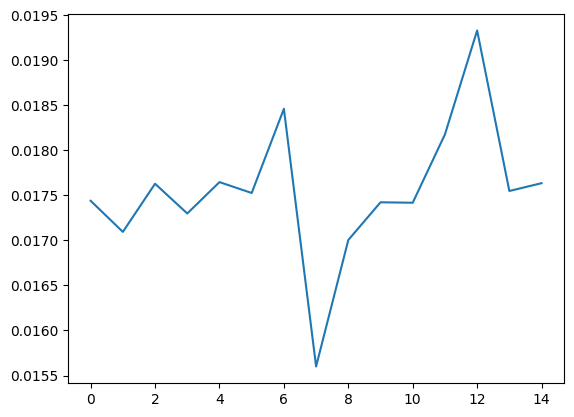

In [15]:
plt.plot(training_loss)

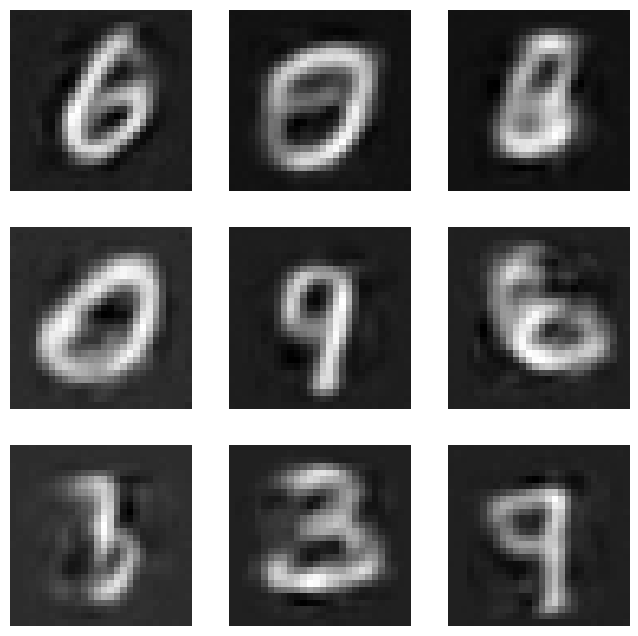

In [21]:
# 合成圖片

model.eval()
with torch.no_grad():
    noise = generate_standard_normal(9, 64).to(device)
    gen_img = model.decode(noise).reshape(-1, 1, 28, 28)
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=3,
        num_col=3,
        is_gray_scale=True,
    )

In [22]:
model_path = artifact_path / 'vae.pth'

In [24]:
torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(model_path))